# **Brain Abnormality Classification**



In this exercise we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.
This exercise has been broken into some smaller sections and each section has its score. What you are supposed to do is shown in `"======== TODO ========"` format. Any part which is showed by `...` should be completed. with There may be some **Questions** in the notes below. It is not necessary to answer these questions, but they will help you to do the next sections.

# Imports

First of all we need to import required libraries.

In [ ]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Download Dataset

The following pieces of code will download dataset to your colab storage and remove corrupted or useless files.

In [ ]:
!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

Streaming output truncated to the last 5000 lines.
./Brain Infection with abscess/58211497.jpg
./Brain Infection with abscess/58211513.jpg
./Brain Infection with abscess/58211529.jpg
./Brain Infection with abscess/58211545.jpg
./Brain Infection with abscess/58211561.jpg
./Brain Infection with abscess/58211577.jpg
./Brain Infection with abscess/58211593.jpg
./Brain Infection with abscess/58211609.jpg
./Brain Infection with abscess/97887252.jpg
./Brain Infection with abscess/97887268.jpg
./Brain Infection with abscess/97887284.jpg
./Brain Infection with abscess/97887300.jpg
./Brain Infection with abscess/97887316.jpg
./Brain Infection with abscess/97887332.jpg
./Brain Infection with abscess/97887348.jpg
./Brain Infection with abscess/97887364.jpg
./Brain Infection with abscess/97887380.jpg
./Brain Infection with abscess/97887396.jpg
./Brain Infection with abscess/97887412.jpg
./Brain Infection with abscess/97887428.jpg
./Brain Infection with abscess/97887444.jpg
./Brain Infection with ab

In [ ]:
# Set the directory containing the images
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [ ]:
# Set up directories and data splits
root_dir = 'dataset'
classes = os.listdir(root_dir)

############## To Do ##############
random.seed(42)

train_split = 0.8
val_split = 0.1
test_split = 0.1
###################################

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

############## To Do ##############
# Create train, validation and test splits
# Also print the number of samples in each class
train_images = []
val_images = []
test_images = []

for cls_name, images in data_dict.items():
    random.shuffle(images)
    number_of_samples = len(images)
    train = int(train_split * number_of_samples)
    val = train + int(val_split * number_of_samples)
    train_images.extend(images[:train])
    val_images.extend(images[train:val])
    test_images.extend(images[val:])
    print(f"{cls_name}: {len(images[:train]) + len(images[train:val]) + len(images[val:])}")
###################################

demyelinating lesions: 38
small meningioma: 36
Cerebral abscess: 36
cerebral venous sinus thrombosis: 76
Brain tumor (Astrocytoma Ganglioglioma): 38
meningioma: 76
Small Vessel Diease Demyelination: 38
Stroke (Haemorrhage): 564
NMOSD  ADEM: 36
focal pachymeningitis: 36
Left Retro-orbital Haemangioma: 112
Ischemic change  demyelinating plaque: 38
Brain tumor - Recurrenceremnant of previous lesion: 114
Brain Atrophy: 264
Glioma: 76
Encephalomalacia with gliotic change: 76
Mid triventricular hydrocephalus: 38
Hemorrhagic collection: 38
Post-operative Status with Small Hemorrhage: 38
Postoperative encephalomalacia: 38
Brain Tumor (Ependymoma): 36
Stroke (Demyelination): 38
Brain Tumor: 76
Brain Infection: 38
Malformation (Chiari I): 38
Stroke(infarct): 906
Brain tumor (Dermoid cyst craniopharyngioma): 38
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis): 74
Obstructive Hydrocephalus: 76
White Matter Disease: 36
Brain tumor operated with ventricular hemorrhage: 76
L

**Question:** How many classes are there in your dataset?

**Question:** Did you notice the imbalance between classes? YES

In [ ]:
#Question: How many classes are there in your dataset?
print("Number of classes:", len(data_dict))

Number of classes: 37


We put samples of each group in a seperate folder.

In [ ]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses: 5

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [ ]:
############## To Do ##############
wgts = []

for c in classes:
    print(c)

    #your code ...

    c_size = len(c)

    # Calculate the weight
    largest_size = max(len(cls) for cls in classes)
    if c_size == largest_size:
        wgt = 1
    else:
        wgt = largest_size / c_size

    wgts.append(wgt)

    print('Size of Class: ' + str(c_size))
    print('Weight of Class: ' + str(wgt))
    print()

wgts = torch.Tensor(wgts)
###################################

demyelinating lesions
Size of Class: 21
Weight of Class: 3.5238095238095237

small meningioma
Size of Class: 16
Weight of Class: 4.625

Cerebral abscess
Size of Class: 16
Weight of Class: 4.625

cerebral venous sinus thrombosis
Size of Class: 32
Weight of Class: 2.3125

Brain tumor (Astrocytoma Ganglioglioma)
Size of Class: 39
Weight of Class: 1.8974358974358974

meningioma
Size of Class: 10
Weight of Class: 7.4

Small Vessel Diease Demyelination
Size of Class: 33
Weight of Class: 2.242424242424242

Stroke (Haemorrhage)
Size of Class: 20
Weight of Class: 3.7

NMOSD  ADEM
Size of Class: 11
Weight of Class: 6.7272727272727275

focal pachymeningitis
Size of Class: 21
Weight of Class: 3.5238095238095237

Left Retro-orbital Haemangioma
Size of Class: 30
Weight of Class: 2.466666666666667

Ischemic change  demyelinating plaque
Size of Class: 37
Weight of Class: 2.0

Brain tumor - Recurrenceremnant of previous lesion
Size of Class: 50
Weight of Class: 1.48

Brain Atrophy
Size of Class: 13
Wei

## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [ ]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index])

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


############## To Do ##############
input_size = (224, 224)

# Define the transformations to be applied on the train and validation sets
transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: x * 0.5 + 0.5),
])


# Create datasets using defined CustomDataset class
train_dataset = CustomDataset(train_images, classes, transforms)
val_dataset = CustomDataset(val_images, classes, transforms)
test_dataset = CustomDataset(test_images, classes, transforms)

# Create dataloaders

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###################################

In [ ]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = len(classes) # Number of classes
num_cls

37

## 1.2) Data Visualization

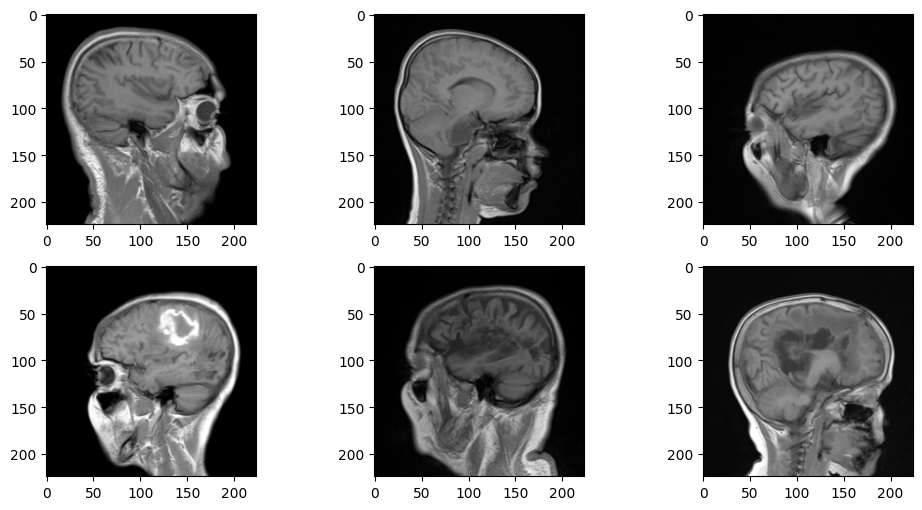

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [ ]:
############## To Do ##############
resnet_model = models.resnet50(pretrained=True)
###################################

# Print the structure of the loaded model
print(resnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 294MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [ ]:
############## To Do ##############
# Your code ...

for param in resnet_model.parameters():
    param.requires_grad = False

classes = 37
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, classes)
###################################

# Print the structure of the modified model and notice the difference
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [ ]:
############## To Do ##############
vgg_model = models.vgg16(pretrained=True)
###################################

# Print the structure of the loaded model
print(vgg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 267MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [ ]:
############## To Do ##############
# Your code ...

# Freeze training for all layers
for param in vgg_model.features.parameters():
    param.require_grad = False

classes = 37
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features,classes)
###################################

# Print the structure of the modified model and notice the difference
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [ ]:
wgts = wgts.to(device)

############## To Do ##############
criterion = nn.CrossEntropyLoss(weight=wgts)
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [ ]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                 # Set model to training mode
                model.train()
            else:
                 # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs, predictions, and losses
                    # Your code ...
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # Your code ...
                        loss.backward()
                        optimizer.step()

                # statistics

                running_loss += loss.item() * inputs.size(0) # Summation of losses
                running_corrects += torch.sum(preds == labels.data) # Summation of true

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # Average of losses. Use running_loss
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # Accuracy. Use running_corrects

            if phase == 'val' and not(scheduler is None):
                scheduler.step(epoch_loss) # Set scheduler

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist
###################################

# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [ ]:
############## To Do ##############
# Your code ...

#in marhale ra dar haman import kardan model anjam dadam aval tamam laye hara freez kardam va baad laye akhar ra ezafe kardam

###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [ ]:
############## To Do ##############
import torch.optim as optim
resnet_optimizer = optim.SGD(resnet_model.fc.parameters(), lr = 0.001)
###################################
from torch.optim import lr_scheduler
lr_scheduler = lr_scheduler.StepLR(resnet_optimizer, step_size = 5, gamma = 0.1) #None dar nazar gereftam

In [ ]:
############## To Do ##############
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None,num_epochs = 30)
###################################

Epoch 0/29
----------
train Loss: 1.7210 Acc: 0.3325
val Loss: 2.3710 Acc: 0.3446

Epoch 1/29
----------
train Loss: 1.7214 Acc: 0.3325
val Loss: 2.3713 Acc: 0.3446

Epoch 2/29
----------
train Loss: 1.7018 Acc: 0.3325
val Loss: 2.3728 Acc: 0.3446

Epoch 3/29
----------
train Loss: 1.7002 Acc: 0.3325
val Loss: 2.3619 Acc: 0.3446

Epoch 4/29
----------
train Loss: 1.6933 Acc: 0.3325
val Loss: 2.3697 Acc: 0.3446

Epoch 5/29
----------
train Loss: 1.6820 Acc: 0.3325
val Loss: 2.3759 Acc: 0.3446

Epoch 6/29
----------
train Loss: 1.6857 Acc: 0.3325
val Loss: 2.3648 Acc: 0.3446

Epoch 7/29
----------
train Loss: 1.6758 Acc: 0.3328
val Loss: 2.3863 Acc: 0.3446

Epoch 8/29
----------
train Loss: 1.6625 Acc: 0.3328
val Loss: 2.3427 Acc: 0.3446

Epoch 9/29
----------
train Loss: 1.6593 Acc: 0.3340
val Loss: 2.3534 Acc: 0.3446

Epoch 10/29
----------
train Loss: 1.6569 Acc: 0.3337
val Loss: 2.3571 Acc: 0.3446

Epoch 11/29
----------
train Loss: 1.6413 Acc: 0.3344
val Loss: 2.2951 Acc: 0.3465

Ep

### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [ ]:
############## To Do ##############
# Your code ...

####در قسمت قبلی انجام شده
#dar import kardan
#in marhale ra dar haman import kardan model anjam dadam aval tamam laye hara freez kardam va baad laye akhar ra ezafe kardam

###################################

### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [ ]:
############## To Do ##############
vgg_optimizer = torch.optim.SGD(vgg_model.classifier[6].parameters(), lr=0.001)
###################################
from torch.optim import lr_scheduler
lr_scheduler = lr_scheduler.StepLR(vgg_optimizer, step_size = 5, gamma = 0.1) #None dar nazar gereftam

In [ ]:
############## To Do ##############
vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=None,num_epochs = 30)
###################################

Epoch 0/29
----------
train Loss: 1.8530 Acc: 0.3335
val Loss: 2.4612 Acc: 0.3446

Epoch 1/29
----------
train Loss: 1.7911 Acc: 0.3333
val Loss: 2.4495 Acc: 0.3446

Epoch 2/29
----------
train Loss: 1.7713 Acc: 0.3328
val Loss: 2.3847 Acc: 0.3446

Epoch 3/29
----------
train Loss: 1.7656 Acc: 0.3328
val Loss: 2.4618 Acc: 0.3446

Epoch 4/29
----------
train Loss: 1.7604 Acc: 0.3328
val Loss: 2.3592 Acc: 0.3446

Epoch 5/29
----------
train Loss: 1.7567 Acc: 0.3333
val Loss: 2.3939 Acc: 0.3446

Epoch 6/29
----------
train Loss: 1.7392 Acc: 0.3325
val Loss: 2.3874 Acc: 0.3446

Epoch 7/29
----------
train Loss: 1.7393 Acc: 0.3359
val Loss: 2.3744 Acc: 0.3446

Epoch 8/29
----------
train Loss: 1.7323 Acc: 0.3330
val Loss: 2.3161 Acc: 0.3446

Epoch 9/29
----------
train Loss: 1.7193 Acc: 0.3344
val Loss: 2.3790 Acc: 0.3446

Epoch 10/29
----------
train Loss: 1.7200 Acc: 0.3354
val Loss: 2.3116 Acc: 0.3465

Epoch 11/29
----------
train Loss: 1.7096 Acc: 0.3342
val Loss: 2.3496 Acc: 0.3446

Ep

# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [ ]:
############## To Do ##############
# Your code ...

for param in resnet_model.parameters():
    param.requires_grad = True

###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [ ]:
############## To Do ##############
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0001)

lr_scheduler = None

resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None,num_epochs = 30)

###################################

Epoch 0/29
----------
train Loss: 1.4448 Acc: 0.4207
val Loss: 1.7436 Acc: 0.4713

Epoch 1/29
----------
train Loss: 0.8993 Acc: 0.5859
val Loss: 1.3351 Acc: 0.5901

Epoch 2/29
----------
train Loss: 0.5339 Acc: 0.7140
val Loss: 1.0330 Acc: 0.6554

Epoch 3/29
----------
train Loss: 0.3203 Acc: 0.8098
val Loss: 1.0078 Acc: 0.6594

Epoch 4/29
----------
train Loss: 0.2547 Acc: 0.8519
val Loss: 0.6761 Acc: 0.7743

Epoch 5/29
----------
train Loss: 0.1704 Acc: 0.8997
val Loss: 0.6016 Acc: 0.8059

Epoch 6/29
----------
train Loss: 0.1010 Acc: 0.9394
val Loss: 0.4511 Acc: 0.8535

Epoch 7/29
----------
train Loss: 0.0985 Acc: 0.9449
val Loss: 0.6887 Acc: 0.7782

Epoch 8/29
----------
train Loss: 0.0732 Acc: 0.9610
val Loss: 0.5431 Acc: 0.8139

Epoch 9/29
----------
train Loss: 0.0726 Acc: 0.9610
val Loss: 0.7025 Acc: 0.7861

Epoch 10/29
----------
train Loss: 0.0498 Acc: 0.9753
val Loss: 0.4074 Acc: 0.8475

Epoch 11/29
----------
train Loss: 0.0432 Acc: 0.9793
val Loss: 0.5159 Acc: 0.8396

Ep

## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [ ]:
############## To Do ##############
# Your code ...

for param in vgg_model.parameters():
    param.requires_grad = True

###################################

### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [ ]:
############## To Do ##############
vgg_optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 0.00008)

lr_schedular = None

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=None,num_epochs = 30)
###################################

Epoch 0/29
----------
train Loss: 1.6798 Acc: 0.3497
val Loss: 2.1978 Acc: 0.3347

Epoch 1/29
----------
train Loss: 1.3927 Acc: 0.4160
val Loss: 1.6768 Acc: 0.4851

Epoch 2/29
----------
train Loss: 1.1179 Acc: 0.5042
val Loss: 1.5413 Acc: 0.5208

Epoch 3/29
----------
train Loss: 0.8457 Acc: 0.5833
val Loss: 1.1606 Acc: 0.5941

Epoch 4/29
----------
train Loss: 0.6392 Acc: 0.6727
val Loss: 1.1365 Acc: 0.6238

Epoch 5/29
----------
train Loss: 0.4864 Acc: 0.7388
val Loss: 0.7852 Acc: 0.7228

Epoch 6/29
----------
train Loss: 0.3268 Acc: 0.8174
val Loss: 0.7588 Acc: 0.7465

Epoch 7/29
----------
train Loss: 0.2971 Acc: 0.8305
val Loss: 0.5800 Acc: 0.7743

Epoch 8/29
----------
train Loss: 0.2322 Acc: 0.8640
val Loss: 0.6081 Acc: 0.7842

Epoch 9/29
----------
train Loss: 0.1809 Acc: 0.9018
val Loss: 0.6165 Acc: 0.7921

Epoch 10/29
----------
train Loss: 0.1382 Acc: 0.9159
val Loss: 0.4824 Acc: 0.8416

Epoch 11/29
----------
train Loss: 0.1082 Acc: 0.9391
val Loss: 0.6303 Acc: 0.8040

Ep

## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

In [ ]:
#resnet_acc_fe, resnet_loss_fe
#یادم رفت اسم را عوض کنم و
#ft
#بگذارم
#به دلیل اشتباه تایپی که داشتم برای مدل رز نت فقط لاس و دقت فاز دوم را ذخیره کردم در واقع اسم وریبل هارا به اشتباه عوض نکرده به همین دلیل دقت و لاس فاز استخراج ویژگی را بصورت دستی اضافه میکنم

In [ ]:
resnet_phase2_train_acc = [tensor.item() for tensor in resnet_acc_fe['train']]
resnet_phase2_val_acc = [tensor.item() for tensor in resnet_acc_fe['val']]

resnet_phase2_train_loss = resnet_loss_fe['train']
resnet_phase2_val_loss = resnet_loss_fe['val']

In [ ]:
#resnet phase 1
data = """
Epoch 0/29
----------
train Loss: 1.7210 Acc: 0.3325
val Loss: 2.3710 Acc: 0.3446

Epoch 1/29
----------
train Loss: 1.7214 Acc: 0.3325
val Loss: 2.3713 Acc: 0.3446

Epoch 2/29
----------
train Loss: 1.7018 Acc: 0.3325
val Loss: 2.3728 Acc: 0.3446

Epoch 3/29
----------
train Loss: 1.7002 Acc: 0.3325
val Loss: 2.3619 Acc: 0.3446

Epoch 4/29
----------
train Loss: 1.6933 Acc: 0.3325
val Loss: 2.3697 Acc: 0.3446

Epoch 5/29
----------
train Loss: 1.6820 Acc: 0.3325
val Loss: 2.3759 Acc: 0.3446

Epoch 6/29
----------
train Loss: 1.6857 Acc: 0.3325
val Loss: 2.3648 Acc: 0.3446

Epoch 7/29
----------
train Loss: 1.6758 Acc: 0.3328
val Loss: 2.3863 Acc: 0.3446

Epoch 8/29
----------
train Loss: 1.6625 Acc: 0.3328
val Loss: 2.3427 Acc: 0.3446

Epoch 9/29
----------
train Loss: 1.6593 Acc: 0.3340
val Loss: 2.3534 Acc: 0.3446

Epoch 10/29
----------
train Loss: 1.6569 Acc: 0.3337
val Loss: 2.3571 Acc: 0.3446

Epoch 11/29
----------
train Loss: 1.6413 Acc: 0.3344
val Loss: 2.2951 Acc: 0.3465

Epoch 12/29
----------
train Loss: 1.6471 Acc: 0.3361
val Loss: 2.3454 Acc: 0.3465

Epoch 13/29
----------
train Loss: 1.6369 Acc: 0.3363
val Loss: 2.3488 Acc: 0.3465

Epoch 14/29
----------
train Loss: 1.6358 Acc: 0.3361
val Loss: 2.2937 Acc: 0.3485

Epoch 15/29
----------
train Loss: 1.6361 Acc: 0.3385
val Loss: 2.2866 Acc: 0.3485

Epoch 16/29
----------
train Loss: 1.6348 Acc: 0.3394
val Loss: 2.2958 Acc: 0.3465

Epoch 17/29
----------
train Loss: 1.6193 Acc: 0.3390
val Loss: 2.2863 Acc: 0.3485

Epoch 18/29
----------
train Loss: 1.6222 Acc: 0.3406
val Loss: 2.3168 Acc: 0.3465

Epoch 19/29
----------
train Loss: 1.6154 Acc: 0.3416
val Loss: 2.2854 Acc: 0.3485

Epoch 20/29
----------
train Loss: 1.6123 Acc: 0.3430
val Loss: 2.2914 Acc: 0.3505

Epoch 21/29
----------
train Loss: 1.6076 Acc: 0.3432
val Loss: 2.2502 Acc: 0.3624

Epoch 22/29
----------
train Loss: 1.6076 Acc: 0.3442
val Loss: 2.2595 Acc: 0.3545

Epoch 23/29
----------
train Loss: 1.5974 Acc: 0.3444
val Loss: 2.2571 Acc: 0.3564

Epoch 24/29
----------
train Loss: 1.6017 Acc: 0.3447
val Loss: 2.2834 Acc: 0.3505

Epoch 25/29
----------
train Loss: 1.5903 Acc: 0.3447
val Loss: 2.2491 Acc: 0.3564

Epoch 26/29
----------
train Loss: 1.5915 Acc: 0.3461
val Loss: 2.2714 Acc: 0.3564

Epoch 27/29
----------
train Loss: 1.5869 Acc: 0.3466
val Loss: 2.2676 Acc: 0.3525

Epoch 28/29
----------
train Loss: 1.5854 Acc: 0.3447
val Loss: 2.2502 Acc: 0.3525

Epoch 29/29
----------
train Loss: 1.5799 Acc: 0.3470
val Loss: 2.2512 Acc: 0.3505
"""
train_loss_resnet = []
train_acc_resnet = []
val_loss_resnet = []
val_acc_resnet = []

lines = data.split('\n')
for line in lines:
    if line.startswith('train Loss:'):
        train_loss_resnet.append(float(line.split(': ')[1].split()[0]))
        train_acc_resnet.append(float(line.split(': ')[2].split()[0]))
    elif line.startswith('val Loss:'):
        val_loss_resnet.append(float(line.split(': ')[1].split()[0]))
        val_acc_resnet.append(float(line.split(': ')[2].split()[0]))

In [ ]:
train_acc_resnet = train_acc_resnet + resnet_phase2_train_acc
val_acc_resnet =  val_acc_resnet + resnet_phase2_val_acc
train_loss_resnet =  train_loss_resnet + resnet_phase2_train_loss
val_loss_resnet =  val_loss_resnet + resnet_phase2_val_loss

In [ ]:
vgg_phase1_train_acc = [tensor.item() for tensor in vgg_acc_fe['train']]
vgg_phase1_val_acc = [tensor.item() for tensor in vgg_acc_fe['val']]

vgg_phase1_train_loss = vgg_loss_fe['train']
vgg_phase1_val_loss = vgg_loss_fe['val']


vgg_phase2_train_acc = [tensor.item() for tensor in vgg_acc_ft['train']]
vgg_phase2_val_acc = [tensor.item() for tensor in vgg_acc_ft['val']]

vgg_phase2_train_loss = vgg_loss_ft['train']
vgg_phase2_val_loss = vgg_loss_ft['val']

In [ ]:
train_acc_vgg = vgg_phase1_train_acc + vgg_phase2_train_acc
val_acc_vgg =  vgg_phase1_val_acc + vgg_phase2_val_acc
train_loss_vgg =  vgg_phase1_train_loss + vgg_phase2_train_loss
val_loss_vgg =  vgg_phase1_val_loss + vgg_phase2_val_loss

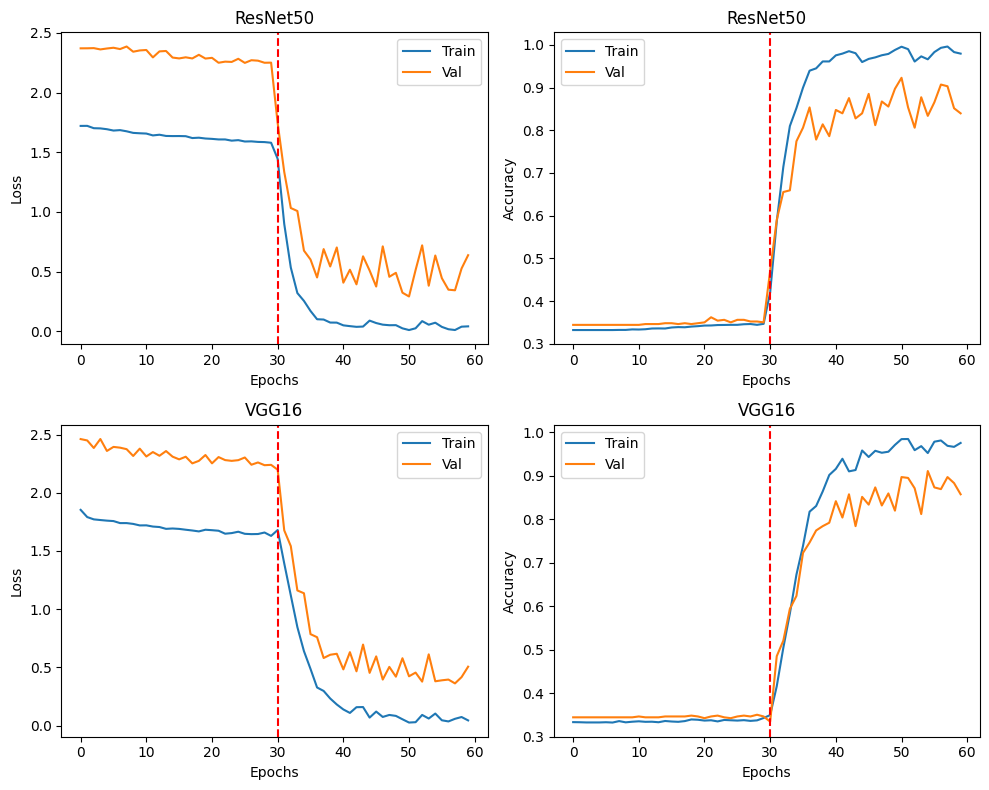

In [ ]:
############## To Do ##############
# Your code ...
plt.figure(figsize=(10, 8))
#renet
plt.subplot(2, 2, 1)
plt.plot(train_loss_resnet, label='Train')
plt.plot(val_loss_resnet, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50')
plt.legend()
plt.axvline(x=30, color='red', linestyle='--')


plt.subplot(2, 2, 2)
plt.plot(train_acc_resnet, label='Train')
plt.plot(val_acc_resnet, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50')
plt.legend()
plt.axvline(x=30, color='red', linestyle='--')

#vgg
plt.subplot(2, 2, 3)
plt.plot(train_loss_vgg, label='Train')
plt.plot(val_loss_vgg, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16')
plt.legend()
plt.axvline(x=30, color='red', linestyle='--')


plt.subplot(2, 2, 4)
plt.plot(train_acc_vgg, label='Train')
plt.plot(val_acc_vgg, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16')
plt.legend()
plt.axvline(x=30, color='red', linestyle='--')

plt.tight_layout()
plt.show()
###################################

## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

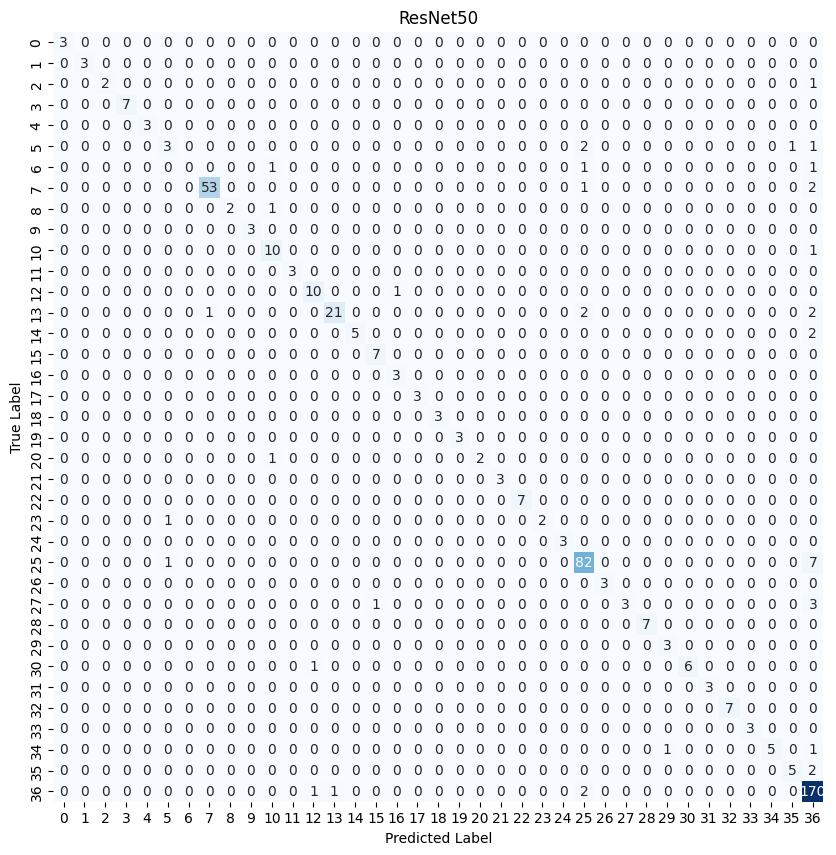

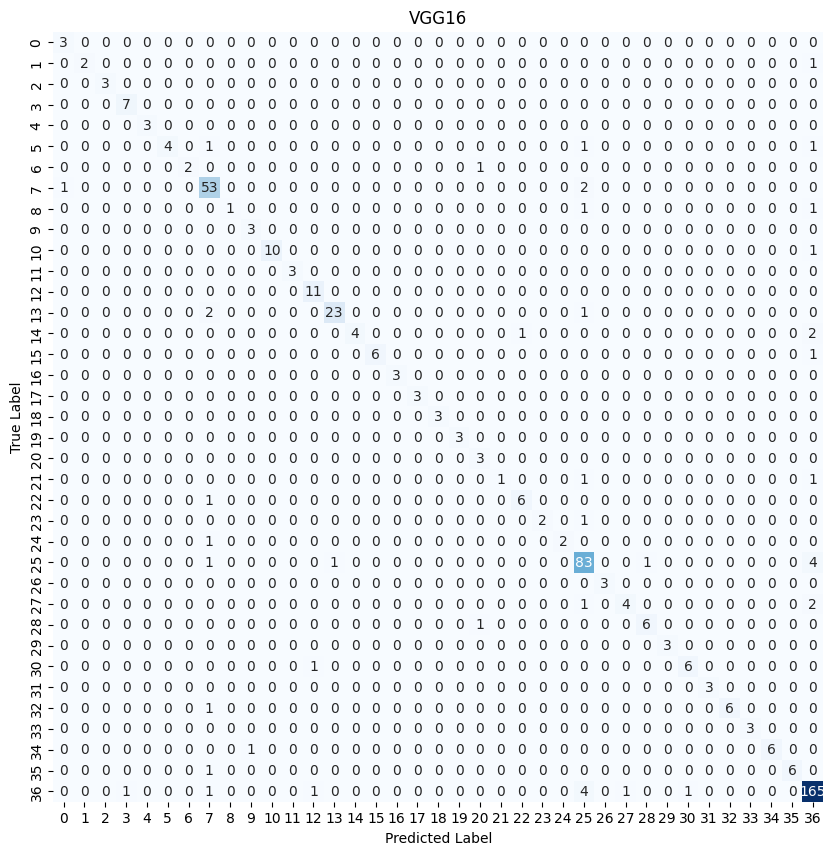

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = [str(i) for i in range(37)]
vgg_predictions = []
resnet_predictions = []
true_labels = []
for _, labels in data_loaders['val']:
    true_labels.extend(labels.tolist())

true_labels = np.array(true_labels)

for inputs, labels in data_loaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    vgg_outputs = vgg_model(inputs)
    _, vgg_preds = torch.max(vgg_outputs, 1)
    vgg_predictions.extend(vgg_preds.cpu().numpy())

    resnet_outputs = resnet_model(inputs)
    _, resnet_preds = torch.max(resnet_outputs, 1)
    resnet_predictions.extend(resnet_preds.cpu().numpy())

resnet_confusion_matrix = confusion_matrix(true_labels, resnet_predictions)
vgg_confusion_matrix = confusion_matrix(true_labels, vgg_predictions)

# Plot for ResNet
plt.figure(figsize=(10, 10))
sns.heatmap(resnet_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes, yticklabels=classes)
plt.title('ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot for VGG
plt.figure(figsize=(10, 10))
sns.heatmap(vgg_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes, yticklabels=classes)
plt.title('VGG16')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

In [ ]:
def acc_calc(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

resnet_accuracy = acc_calc(resnet_model, test_loader)
vgg_accuracy = acc_calc(vgg_model, test_loader)

print(f'ResNet Acc: {resnet_accuracy:.4f}')
print(f'VGG Acc: {vgg_accuracy:.4f}')


ResNet Acc: 0.9075
VGG Acc: 0.8778


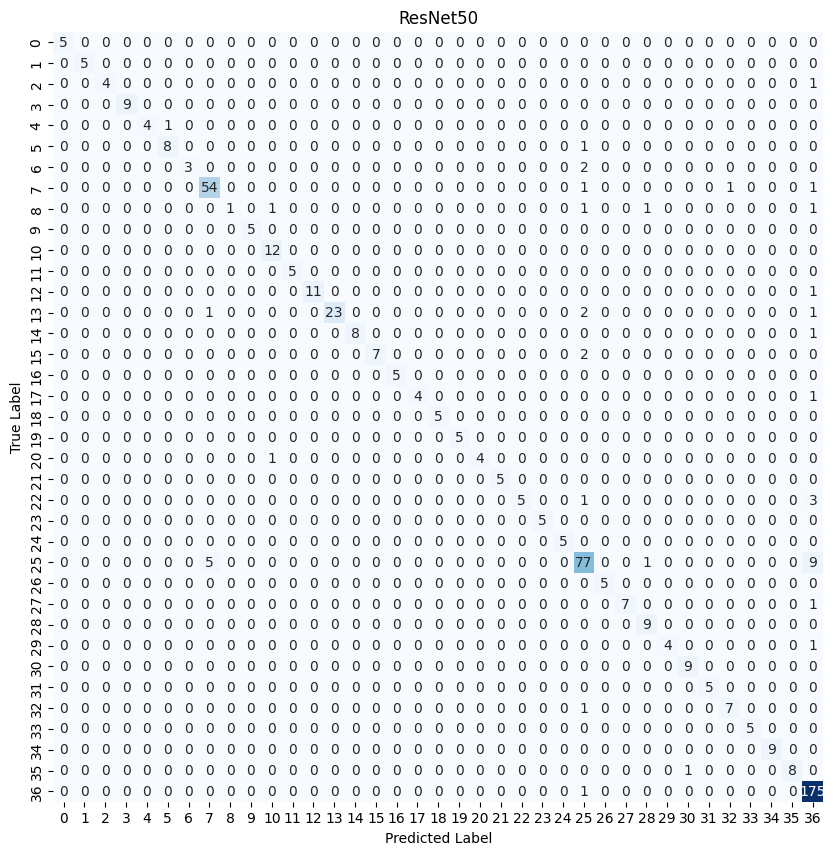

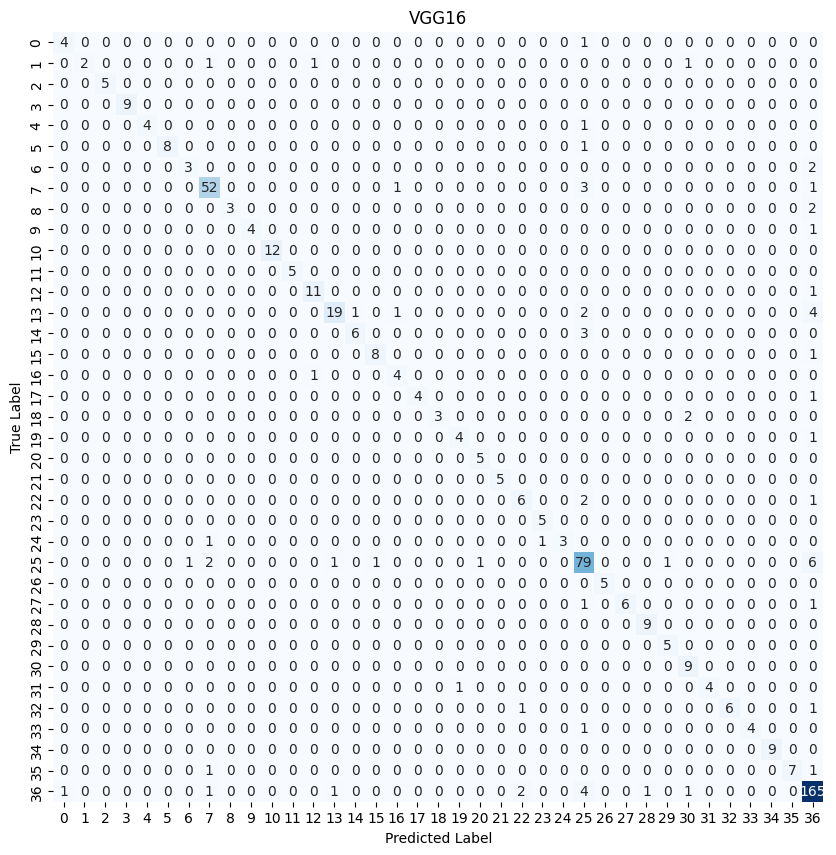

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

classes = [str(i) for i in range(37)]
vgg_predictions = []
resnet_predictions = []
true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.tolist())

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    vgg_outputs = vgg_model(inputs)
    _, vgg_preds = torch.max(vgg_outputs, 1)
    vgg_predictions.extend(vgg_preds.cpu().numpy())

    resnet_outputs = resnet_model(inputs)
    _, resnet_preds = torch.max(resnet_outputs, 1)
    resnet_predictions.extend(resnet_preds.cpu().numpy())

resnet_confusion_matrix = confusion_matrix(true_labels, resnet_predictions)
vgg_confusion_matrix = confusion_matrix(true_labels, vgg_predictions)

# Plot for ResNet
plt.figure(figsize=(10, 10))
sns.heatmap(resnet_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes, yticklabels=classes)
plt.title('ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot for VGG
plt.figure(figsize=(10, 10))
sns.heatmap(vgg_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes, yticklabels=classes)
plt.title('VGG16')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()